# Demo main

In [1]:
from preprocess.tissue_mask import GaussianTissueMask
from preprocess.utils import describe_img, read_image, get_tissue_mask, get_image_patches, resize_patch, normalize_patch, convert_patch_to_tensor

from osgen.loss import structure_preservation_loss, color_alignment_loss, content_loss, style_loss, total_loss
from osgen.pipeline import StyleTransferPipeline
from osgen.vit import extract_style_embedding

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("darkgrid")
from PIL import Image

/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define hyperparameters

In [2]:
Image.MAX_IMAGE_PIXELS = 100000000000

IMAGE_PATH = "/Users/hoangthuyduongvu/Desktop/BiOSGen/data/HE/A3_TMA_15_02_IVB_HE.png"
STYLE_PATH = "/Users/hoangthuyduongvu/Desktop/BiOSGen/data/NKX3/A6_TMA_15_02_IIB_NKX.png"

# tissue mask params
tissue_mask_params = {
    'kernel_size': 20,
    'sigma': 20,
    'downsample': 8,
    'background_gray_threshold': 220
}

# patch extraction params
patch_extraction_params = {
    'patch_size': 128,
    'patch_tissue_threshold': 0.7,
    'is_visualize': False
}

## Process patches

In [3]:
image_src = read_image(IMAGE_PATH)
image_dst = read_image(STYLE_PATH)

In [4]:
tissue_mask_src = get_tissue_mask(image=image_src, **tissue_mask_params)
tissue_mask_dst = get_tissue_mask(image=image_dst, **tissue_mask_params)

Original size: 5896x5896
Downsampling factor: 8
New size: 737x737
Original size: 5684x5684
Downsampling factor: 8
New size: 710x710


In [5]:
# extract src patches
patches_src = get_image_patches(
    image=image_src,
    tissue_mask=tissue_mask_src,
    **patch_extraction_params
)

# extract dst patches
patches_dst = get_image_patches(
    image=image_dst,
    tissue_mask=tissue_mask_dst,
    **patch_extraction_params
)

## Load patches

In [6]:
batch_size = 1
batch_src = patches_src[:batch_size]
batch_dst = patches_dst[:batch_size]

batch_src = torch.Tensor(batch_src).permute(0, 3, 1, 2)
batch_dst = torch.Tensor(batch_dst).permute(0, 3, 1, 2)

# Check shape
print(batch_src.shape)
print(batch_dst.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


/var/folders/9t/hj30jvr52kscxxdg1z2kq1600000gn/T/ipykernel_43500/208333741.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  batch_src = torch.Tensor(batch_src).permute(0, 3, 1, 2)


# Test

In [7]:
tmp = StyleTransferPipeline()
style_emb = extract_style_embedding(patches_dst[0], device='cpu')
print(style_emb.shape)
out = tmp(batch_src[0].unsqueeze(0), style_emb, torch.Tensor([0,200,400,1000]))

Image Features Shape: torch.Size([1, 512])
Transformed Style Embedding Shape: torch.Size([1, 256])
torch.Size([1, 256])
Mean shape: torch.Size([1, 4, 32, 32]), Log Variance shape: torch.Size([1, 4, 32, 32])
Z shape: torch.Size([1, 4, 32, 32]), Condition shape: torch.Size([1, 256])
Conditioned Z shape: torch.Size([1, 4, 32, 32])

VAE Encoder Output Shape: torch.Size([1, 4, 32, 32]) 

After Conv2d: torch.Size([1, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After ResBlock: torch.Size([4, 32, 32, 32])
After Downsample: torch.Size([4, 32, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After ResBlock: torch.Size([4, 64, 16, 16])
After Downsample: torch.Size([4, 64, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
After ResBlock: torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 128, 8, 8])
Upsampling: h=torch.Size([4, 128, 8, 8]), skip=torch.Size([4, 64, 8, 8])

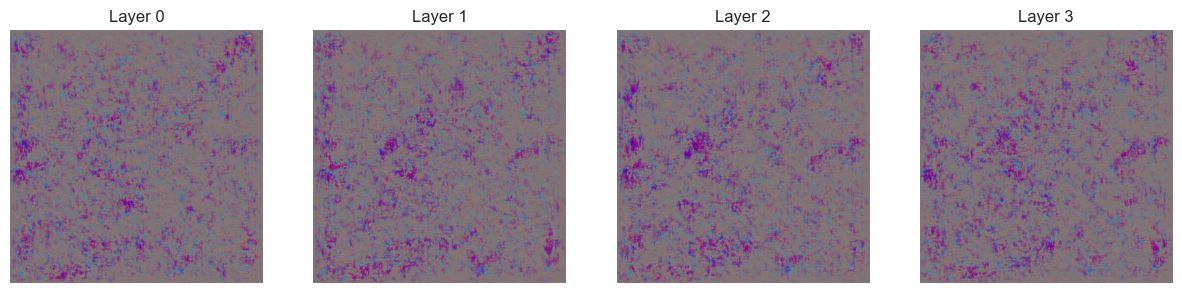

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i in range(len(out)):
    ax[i].imshow(out[i].detach().numpy().transpose(1, 2, 0))
    ax[i].axis('off')
    ax[i].set_title(f'Layer {i}')
plt.show()

# Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np 

class PatchDataset(Dataset):
    def __init__(self, path_src, path_dst, tissue_mask_params, patch_extraction_params, batch_size):
        self.image_src = read_image(path_src)
        self.image_dst = read_image(path_dst)
        self.tissue_mask_src = get_tissue_mask(image=self.image_src, **tissue_mask_params)
        self.tissue_mask_dst = get_tissue_mask(image=self.image_dst, **tissue_mask_params)
        self.patch_extraction_params = patch_extraction_params
        self.patches_src = get_image_patches(
            image=self.image_src,
            tissue_mask=self.tissue_mask_src,
            **patch_extraction_params
        )
        self.patches_dst = get_image_patches(
            image=self.image_dst,
            tissue_mask=self.tissue_mask_dst,
            **patch_extraction_params
        )
        self.batch_size = batch_size
        self.batch = self.patches_src[:batch_size]

        # Preprocess batch
        for i in range(len(self.batch)):
            self.batch[i] = resize_patch(self.batch[i])
            self.batch[i] = normalize_patch(self.batch[i])
        
        self.batch = convert_patch_to_tensor(self.batch)

    def __len__(self):
        return len(self.batch)

    def __getitem__(self, idx):
        return self.batch[idx], self.patches_dst[np.random.randint(len(self.patches_dst))]        

In [17]:
# Create dataset
batch_size = 10
dataset = PatchDataset(IMAGE_PATH, STYLE_PATH, tissue_mask_params, patch_extraction_params, batch_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Original size: 5896x5896
Downsampling factor: 8
New size: 737x737
Original size: 5684x5684
Downsampling factor: 8
New size: 710x710


In [26]:
dataset.patches_dst[0].shape

(128, 128, 3)

In [ ]:
for batch, style in dataloader:
    print(batch.shape)
    print(style[0].numpy())
    print()

torch.Size([1, 3, 32, 32])
[[[143 163 198]
  [139 162 203]
  [132 161 205]
  ...
  [ 90 106 119]
  [103 118 125]
  [112 128 127]]

 [[144 165 196]
  [141 165 201]
  [137 166 208]
  ...
  [104 119 126]
  [115 129 129]
  [124 139 132]]

 [[139 159 186]
  [139 162 193]
  [136 164 203]
  ...
  [117 135 149]
  [126 145 151]
  [135 153 157]]

 ...

 [[203 201 214]
  [178 177 195]
  [141 142 163]
  ...
  [248 246 255]
  [244 244 255]
  [242 242 252]]

 [[219 216 227]
  [203 200 217]
  [174 175 195]
  ...
  [248 248 255]
  [243 243 255]
  [240 240 252]]

 [[232 230 244]
  [222 220 241]
  [201 202 223]
  ...
  [249 249 255]
  [242 242 254]
  [235 237 249]]]

torch.Size([1, 3, 32, 32])
[[[232 228 242]
  [237 234 245]
  [238 237 243]
  ...
  [241 239 240]
  [243 241 242]
  [244 242 245]]

 [[240 236 250]
  [242 240 253]
  [243 244 249]
  ...
  [250 248 249]
  [249 247 248]
  [249 247 248]]

 [[241 239 253]
  [243 241 254]
  [241 242 247]
  ...
  [249 247 248]
  [248 246 247]
  [247 245 246]]

 ..

# Train